# Using Python to analyze ECG signals

Author: Chun-Chia Yang

## Introduction

This notebook is tring to analyze the changes of ECG signals in different states. The data comes from CEBS database. I downloaded three files containing ECG signals in three different states of the same subject respectively. By calculating the PSD (power spectral density) of ECG signals,we can learn a lot of information about our physiological state. Therefore,I will try to compute PSD of the ECG dataset and show figures about the analysis result.

### Import Python packages and modules

In [1]:
import numpy as np
from requests_html import HTMLSession
import wfdb
from matplotlib import pyplot as plt
from scipy.signal import find_peaks
from scipy.interpolate import interp1d
from IPython.display import HTML,Image

## Prcossing data (in  relax state)

### Obtaining data from CEBS database

In [2]:
#TO pull the data using the API
api='b001.hea'
url='https://physionet.org/physiobank/database/cebsdb/'+api
session=HTMLSession()
response=session.get(url)
data=response.content

The data is in a HEA file,kind of form in WFDB format.

In [3]:
with open('b001.hea', 'wb') as f:
    f.write(data)

### Exploring data

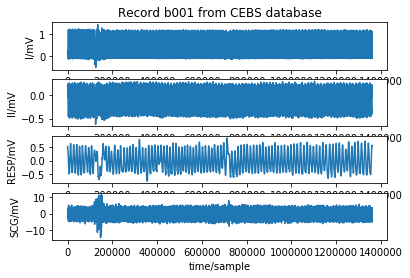

{'record_name': 'b001',
 'n_sig': 4,
 'fs': 5000,
 'counter_freq': None,
 'base_counter': None,
 'sig_len': 1360050,
 'base_time': None,
 'base_date': None,
 'comments': ['Baseline for subject 1'],
 'sig_name': ['I', 'II', 'RESP', 'SCG'],
 'p_signal': array([[ 0.16297957,  0.18371695,  0.52520144, -0.18313714],
        [ 0.16268303,  0.18371695,  0.52520144, -0.18313714],
        [ 0.16268303,  0.18402153,  0.52520144, -0.18313714],
        ...,
        [ 0.02410888, -0.30333371,  0.55450547, -4.97434578],
        [ 0.01648774, -0.29815585,  0.55450547, -5.00480095],
        [ 0.00886661, -0.29326873,  0.55450547, -5.03525613]]),
 'd_signal': None,
 'e_p_signal': None,
 'e_d_signal': None,
 'file_name': ['b001.dat', 'b001.dat', 'b001.dat', 'b001.dat'],
 'fmt': ['16', '16', '16', '16'],
 'samps_per_frame': [1, 1, 1, 1],
 'skew': [None, None, None, None],
 'byte_offset': [None, None, None, None],
 'adc_gain': [33722.0181, 72230.6799, 40950.0021, 2462.6354],
 'baseline': [-14974, 11980, -

In [4]:
#Read and display the data 
record = wfdb.rdrecord('b001') 
wfdb.plot_wfdb(record=record, title='Record b001 from CEBS database')
display(record.__dict__)

### What is an ECG?
It is used to record the electrical activity of the heart from different angles to identify and locate pathology.
[https://geekymedics.com/understanding-an-ecg/](https://geekymedics.com/understanding-an-ecg/)

In [5]:
Image(width=300, height=300,url="https://geekymedics.com/wp-content/uploads/2011/03/SinusRhythmLabels.jpg")

### Extract raw lead I ECG signals


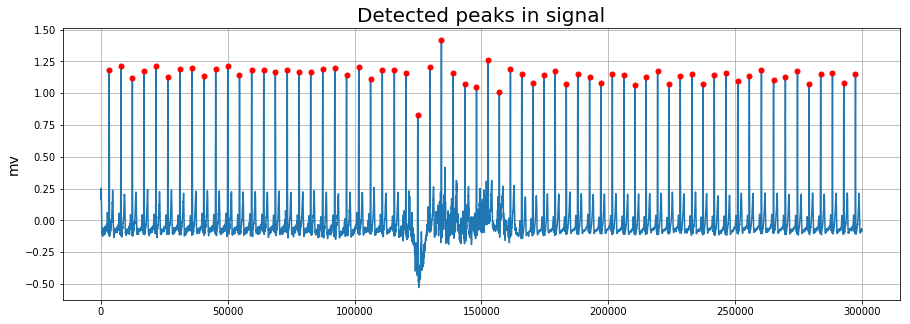

In [6]:
#Extract ECG signals and the length of signals is 1 min
signals,fields=wfdb.rdsamp('b001',channels=[0],sampfrom=0,sampto=300000)
signals_x=np.arange(300000)
#Change signal dimension from 2D to 1D
signals=signals.flatten()
#find the position of all the R-peaks
r_index,_=find_peaks(signals,distance=4000)
#Plot signals and mark the R-peaks
plt.figure(figsize=(15, 5)) 
plt.plot(signals_x,signals)
plt.plot(r_index,signals[r_index],marker="o",ls="",ms=5,color='r')
plt.title("Detected peaks in signal",fontsize=20)
plt.ylabel('mv',fontsize=14)
plt.grid()

### What is RR-interval?
The RR-interval starts at the peak of one R wave and ends at the peak of the next R wave.

It represents the time between two QRS complexes.
[https://bit.ly/2Oi721v](https://bit.ly/2Oi721v)

In [7]:
Image(width=400, height=300,url= "https://www.researchgate.net/profile/Tolga_Soyata/publication/281176903/figure/fig7/AS:284472848207872@1444835020089/Typical-ECG-trace-with-QT-and-RR-intervals-labeled-Image-based-on.png")

## Analysing data

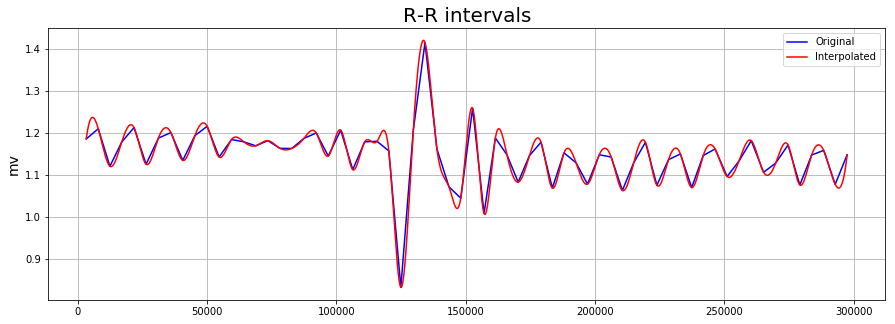

In [8]:
#Interpolate the R-peaks data
r_index_new = np.linspace(np.min(r_index),np.max(r_index),300000)
f = interp1d(r_index,signals[r_index], kind='cubic')
#Plot the original and interpolated R-peaks respectively
plt.figure(figsize=(15, 5))
plt.plot(r_index,signals[r_index], label="Original", color='blue')
plt.plot(r_index_new, f(r_index_new), label="Interpolated", color='red')
plt.title("R-R intervals",fontsize=20)
plt.ylabel('mv',fontsize=14)
plt.grid()
plt.legend()

### What is HRV
[https://www.health.com/heart-disease/heart-rate-variability](https://www.health.com/heart-disease/heart-rate-variability)

In [29]:
%%HTML 
<iframe width="640" height="360" src="https://www.youtube.com/embed/B6Id6Jl7_HU" frameborder="0" allow="autoplay; encrypted-media" allowfullscreen></iframe>

<video width="500" height="300" src="http://timeinc.brightcove.com.edgesuite.net/rtmp_uds/1125866826/201803/799/1125866826_5747024689001_5747021315001.mp4?pubId=1125866826&videoId=5747021315001" controls>
</video>

[![Everything Is AWESOME](https://i.ytimg.com/vi/B6Id6Jl7_HU/hqdefault.jpg?sqp=-oaymwEZCNACELwBSFXyq4qpAwsIARUAAIhCGAFwAQ==&rs=AOn4CLA0iOqz6ZZvAt8lO0X0W4-m6UL7Iw)](https://www.youtube.com/watch?v=B6Id6Jl7_HU)

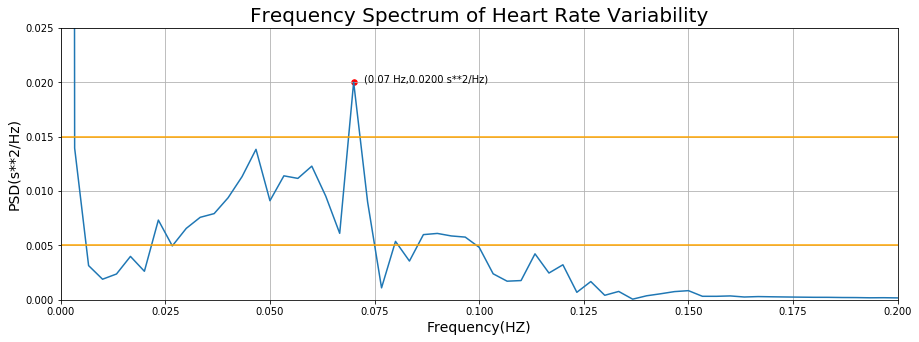

In [10]:
#Length of the signals
n=signals_x.size
freq=np.fft.fftfreq(n,d=1/1000)
#Get single side of the frequency range
freq=freq[range(n//2)]
#Do FFT
Y=np.fft.fft(f(r_index_new))/n
#Return one side of the FFT
Y=Y[range(n//2)]
Y=abs(Y)
#Plot HRV in frequency domain
fig=plt.figure(figsize=(15, 5))
plt.plot(freq,Y)
Y=Y[1:]
Y_x=Y.argmax(axis=0)+1
Y_max=float(Y.max())
plt.scatter(freq[Y_x],Y_max,s=30,color='r')
plt.annotate('({} Hz,{:.4f} s**2/Hz)'.format(freq[Y_x],Y_max),xy=(freq[Y_x]+0.0025,Y_max),xycoords='data')
plt.title("Frequency Spectrum of Heart Rate Variability",fontsize=20)
plt.xlim(0,0.2) 
plt.ylim(0,0.025)
plt.xlabel('Frequency(HZ)',fontsize=14)
plt.ylabel('PSD(s**2/Hz)',fontsize=14)
plt.axhline(0.015,color='orange')
plt.axhline(0.005,color='orange')
plt.grid()

## Prcossing data (in a state to listen classical music)

### Obtaining data from CEBS database

In [11]:
#TO pull the data using the API
api='m001.dat'
url='https://physionet.org/physiobank/database/cebsdb/'+api
session=HTMLSession()
response=session.get(url)
data=response.content

with open('m001.dat', 'wb') as f:
    f.write(data)

### Exploring data

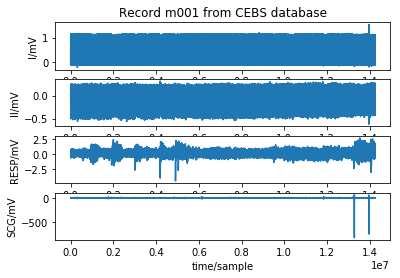

{'record_name': 'm001',
 'n_sig': 4,
 'fs': 5000,
 'counter_freq': None,
 'base_counter': None,
 'sig_len': 14246750,
 'base_time': None,
 'base_date': None,
 'comments': ['Long measurement for subject 1'],
 'sig_name': ['I', 'II', 'RESP', 'SCG'],
 'p_signal': array([[-9.30910096e-02, -5.43232542e-02,  0.00000000e+00,
          2.43987736e-01],
        [-9.30910096e-02, -5.43232542e-02,  0.00000000e+00,
          3.11762107e-01],
        [-9.30910096e-02, -5.40108884e-02, -3.30103389e-04,
          3.38871855e-01],
        ...,
        [-4.67073084e-02,  2.28878949e-02, -2.19408719e-01,
          2.16877987e-01],
        [-4.64106685e-02,  2.32002607e-02, -2.19408719e-01,
          2.16877987e-01],
        [-4.64106685e-02,  2.32002607e-02, -2.19738823e-01,
          2.16877987e-01]]),
 'd_signal': None,
 'e_p_signal': None,
 'e_d_signal': None,
 'file_name': ['m001.dat', 'm001.dat', 'm001.dat', 'm001.dat'],
 'fmt': ['16', '16', '16', '16'],
 'samps_per_frame': [1, 1, 1, 1],
 'skew': [

In [12]:
record = wfdb.rdrecord('m001') 
wfdb.plot_wfdb(record=record, title='Record m001 from CEBS database')
display(record.__dict__)

### Extract raw lead I ECG signals

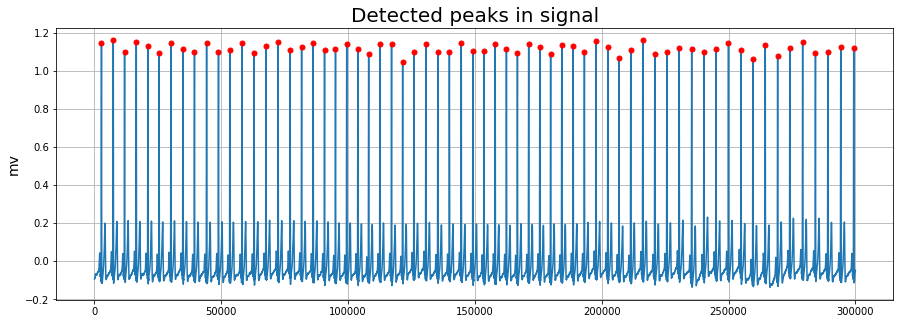

In [13]:
#Extract ECG signals and the length of signals is 1 min
signals,fields=wfdb.rdsamp('m001',channels=[0],sampfrom=0,sampto=300000)
signals_x=np.arange(300000)
#Change signal dimension from 2D to 1D
signals=signals.flatten()
#find the position of all the R-peaks
r_index,_=find_peaks(signals,distance=4000)
#Plot signals and mark the R-peaks
plt.figure(figsize=(15, 5)) 
plt.plot(signals_x,signals)
plt.plot(r_index,signals[r_index],marker="o",ls="",ms=5,color='r')
plt.title("Detected peaks in signal",fontsize=20)
plt.ylabel('mv',fontsize=14)
plt.grid()

## Analysing data

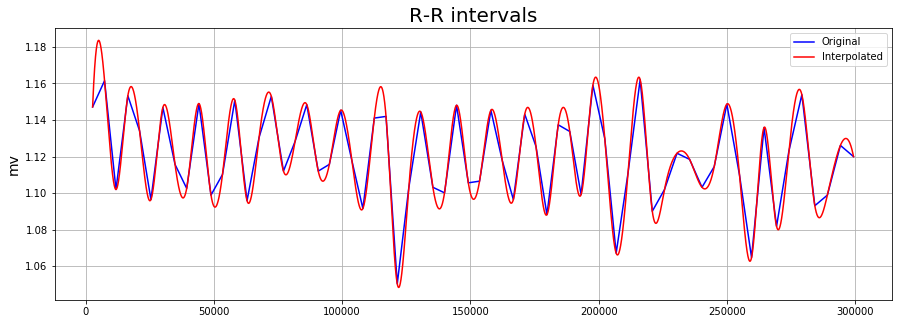

In [14]:
#Interpolate the R-peaks data
r_index_new = np.linspace(np.min(r_index),np.max(r_index),300000)
f = interp1d(r_index,signals[r_index], kind='cubic')
#Plot the original and interpolated R-peaks respectively
plt.figure(figsize=(15, 5))
plt.plot(r_index,signals[r_index], label="Original", color='blue')
plt.plot(r_index_new, f(r_index_new), label="Interpolated", color='red')
plt.title("R-R intervals",fontsize=20)
plt.ylabel('mv',fontsize=14)
plt.grid()
plt.legend()

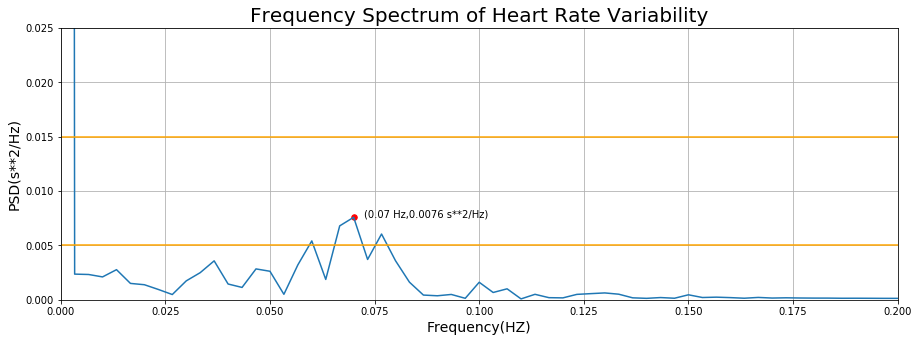

In [15]:
#Length of the signals
n=signals_x.size
freq=np.fft.fftfreq(n,d=1/1000)
#Get single side of the frequency range
freq=freq[range(n//2)]
#Do FFT
Y=np.fft.fft(f(r_index_new))/n
#Return one side of the FFT
Y=Y[range(n//2)]
Y=abs(Y)
#Plot HRV in frequency domain
fig=plt.figure(figsize=(15, 5))
plt.plot(freq,Y)
Y=Y[1:]
Y_x=Y.argmax(axis=0)+1
Y_max=float(Y.max())
plt.scatter(freq[Y_x],Y_max,s=30,color='r')
plt.annotate('({} Hz,{:.4f} s**2/Hz)'.format(freq[Y_x],Y_max),xy=(freq[Y_x]+0.0025,Y_max),xycoords='data')
plt.title("Frequency Spectrum of Heart Rate Variability",fontsize=20)
plt.xlim(0,0.2) 
plt.ylim(0,0.025)
plt.xlabel('Frequency(HZ)',fontsize=14)
plt.ylabel('PSD(s**2/Hz)',fontsize=14)
plt.axhline(0.015,color='orange')
plt.axhline(0.005,color='orange')
plt.grid()

## Prcossing data (after in a state to listen classical music)

### Obtaining data from CEBS database

In [16]:
#TO pull the data using the API
api='p001.dat'
url='https://physionet.org/physiobank/database/cebsdb/'+api
session=HTMLSession()
response=session.get(url)
data=response.content

with open('p001.dat', 'wb') as f:
    f.write(data)

### Exploring data

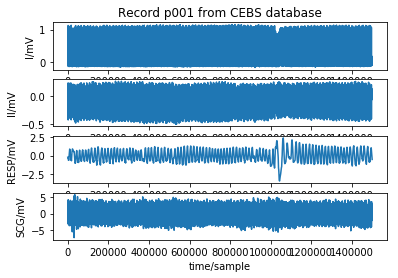

{'record_name': 'p001',
 'n_sig': 4,
 'fs': 5000,
 'counter_freq': None,
 'base_counter': None,
 'sig_len': 1500000,
 'base_time': None,
 'base_date': None,
 'comments': ['After music listening for subject 1'],
 'sig_name': ['I', 'II', 'RESP', 'SCG'],
 'p_signal': array([[-0.05401741, -0.02410962, -0.22583614,  0.06103516],
        [-0.05431784, -0.02410962, -0.22610617,  0.09155273],
        [-0.05431784, -0.02410962, -0.22610617,  0.12207031],
        ...,
        [-0.02593717,  0.00122432, -0.53133149, -0.42724609],
        [-0.02533631,  0.00151862, -0.53160152, -0.42724609],
        [-0.02503588,  0.00213078, -0.53160152, -0.39672852]]),
 'd_signal': None,
 'e_p_signal': None,
 'e_d_signal': None,
 'file_name': ['p001.dat', 'p001.dat', 'p001.dat', 'p001.dat'],
 'fmt': ['16', '16', '16', '16'],
 'samps_per_frame': [1, 1, 1, 1],
 'skew': [None, None, None, None],
 'byte_offset': [None, None, None, None],
 'adc_gain': [49928.3449, 84945.3367, 11109.8252, 4947.968],
 'baseline': [-249

In [17]:
record = wfdb.rdrecord('p001') 
wfdb.plot_wfdb(record=record, title='Record p001 from CEBS database')
display(record.__dict__)

### Extract raw lead I ECG signals

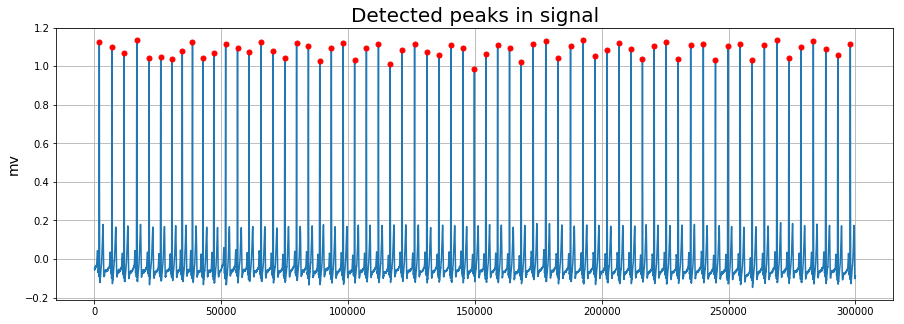

In [21]:
#Extract ECG signals and the length of signals is 1 min
signals,fields=wfdb.rdsamp('p001',channels=[0],sampfrom=0,sampto=300000)
signals_x=np.arange(300000)
#Change signal dimension from 2D to 1D
signals=signals.flatten()
#find the position of all the R-peaks
r_index,_=find_peaks(signals,distance=4000)
#Plot signals and mark the R-peaks
plt.figure(figsize=(15, 5)) 
plt.plot(signals_x,signals)
plt.plot(r_index,signals[r_index],marker="o",ls="",ms=5,color='r')
plt.title("Detected peaks in signal",fontsize=20)
plt.ylabel('mv',fontsize=14)
plt.grid()

## Analysing data

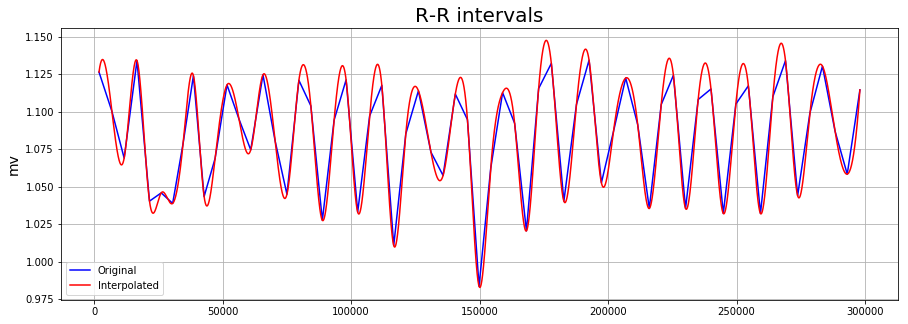

In [22]:
#Interpolate the R-peaks data
r_index_new = np.linspace(np.min(r_index),np.max(r_index),300000)
f = interp1d(r_index,signals[r_index], kind='cubic')
#Plot the original and interpolated R-peaks respectively
plt.figure(figsize=(15, 5))
plt.plot(r_index,signals[r_index], label="Original", color='blue')
plt.plot(r_index_new, f(r_index_new), label="Interpolated", color='red')
plt.title("R-R intervals",fontsize=20)
plt.ylabel('mv',fontsize=14)
plt.grid()
plt.legend()

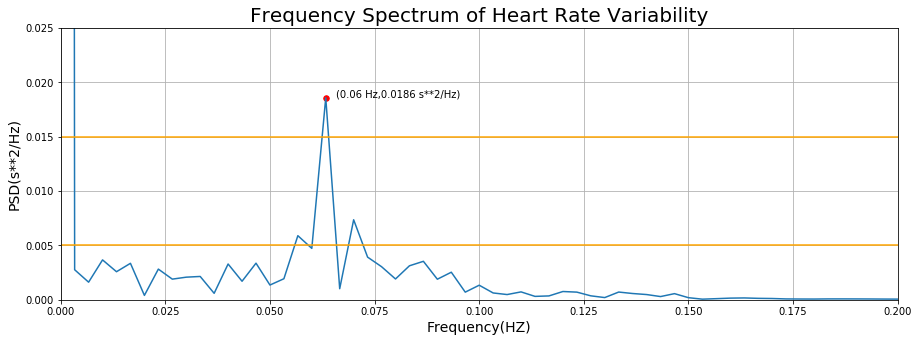

In [23]:
#Length of the signals
n=signals_x.size
freq=np.fft.fftfreq(n,d=1/1000)
#Get single side of the frequency range
freq=freq[range(n//2)]
#Do FFT
Y=np.fft.fft(f(r_index_new))/n
#Return one side of the FFT
Y=Y[range(n//2)]
Y=abs(Y)
#Plot HRV in frequency domain
fig=plt.figure(figsize=(15, 5))
plt.plot(freq,Y)
Y=Y[1:]
Y_x=Y.argmax(axis=0)+1
Y_max=float(Y.max())
plt.scatter(freq[Y_x],Y_max,s=30,color='r')
plt.annotate('({:.2f} Hz,{:.4f} s**2/Hz)'.format(freq[Y_x],Y_max),xy=(freq[Y_x]+0.0025,Y_max),xycoords='data')
plt.title("Frequency Spectrum of Heart Rate Variability",fontsize=20)
plt.xlim(0,0.2) 
plt.ylim(0,0.025)
plt.xlabel('Frequency(HZ)',fontsize=14)
plt.ylabel('PSD(s**2/Hz)',fontsize=14)
plt.axhline(0.015,color='orange')
plt.axhline(0.005,color='orange')
plt.grid()

## Analysis result

## References